In [5]:
import cv2
import mediapipe as mp
import numpy as np
import os
import joblib
import re
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Paths
DATASET_PATH = "D:/University_Stuff/Year2/Semester2/Artificial_Intelligence/ProjectAI/AlphabetDataset/asl_dataset"

# Verify if the dataset path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

LABELS = sorted([folder for folder in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, folder))])

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Function to extract label from filename
def extract_label_from_filename(filename):
    match = re.search(r'_([a-z0-9])_', filename)
    return match.group(1) if match else None

# Function to extract hand landmarks
def extract_landmarks(image_path):
    if not os.path.isfile(image_path):
        return None  # Ensure we only process files
    
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Unable to load image {image_path}")
        return None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        landmarks = []
        for hand_landmarks in results.multi_hand_landmarks:
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])

        # Extract relative path
        relative_path = os.path.relpath(image_path, DATASET_PATH)
        print(f"Successfully extracted landmarks from: {relative_path}")  # Debugging output
        return landmarks
    return None

# Prepare dataset
X, y = [], []
for label in LABELS:
    label_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(label_path):
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            if not os.path.isfile(img_path):
                continue  # Skip directories
            extracted_label = extract_label_from_filename(img_file)
            if extracted_label:
                landmarks = extract_landmarks(img_path)
                if landmarks:
                    X.append(landmarks)
                    y.append(extracted_label)
                    
                    # Extract relative path
                    relative_path = os.path.relpath(img_path, DATASET_PATH)
                    print(f"File used for training: {relative_path} - Label: {extracted_label}")  # Debugging output


Successfully extracted landmarks from: 0\hand1_0_bot_seg_1_cropped.jpeg
File used for training: 0\hand1_0_bot_seg_1_cropped.jpeg - Label: 0
Successfully extracted landmarks from: 0\hand1_0_bot_seg_2_cropped.jpeg
File used for training: 0\hand1_0_bot_seg_2_cropped.jpeg - Label: 0
Successfully extracted landmarks from: 0\hand1_0_bot_seg_4_cropped.jpeg
File used for training: 0\hand1_0_bot_seg_4_cropped.jpeg - Label: 0
Successfully extracted landmarks from: 0\hand1_0_bot_seg_5_cropped.jpeg
File used for training: 0\hand1_0_bot_seg_5_cropped.jpeg - Label: 0
Successfully extracted landmarks from: 0\hand1_0_dif_seg_1_cropped.jpeg
File used for training: 0\hand1_0_dif_seg_1_cropped.jpeg - Label: 0
Successfully extracted landmarks from: 0\hand1_0_dif_seg_3_cropped.jpeg
File used for training: 0\hand1_0_dif_seg_3_cropped.jpeg - Label: 0
Successfully extracted landmarks from: 0\hand1_0_dif_seg_4_cropped.jpeg
File used for training: 0\hand1_0_dif_seg_4_cropped.jpeg - Label: 0
Successfully extract

In [6]:

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Ensure dataset is not empty
if len(X) == 0 or len(y) == 0:
    raise ValueError("No valid hand landmarks found in dataset. Check dataset structure.")

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate Model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')


Model Accuracy: 0.95


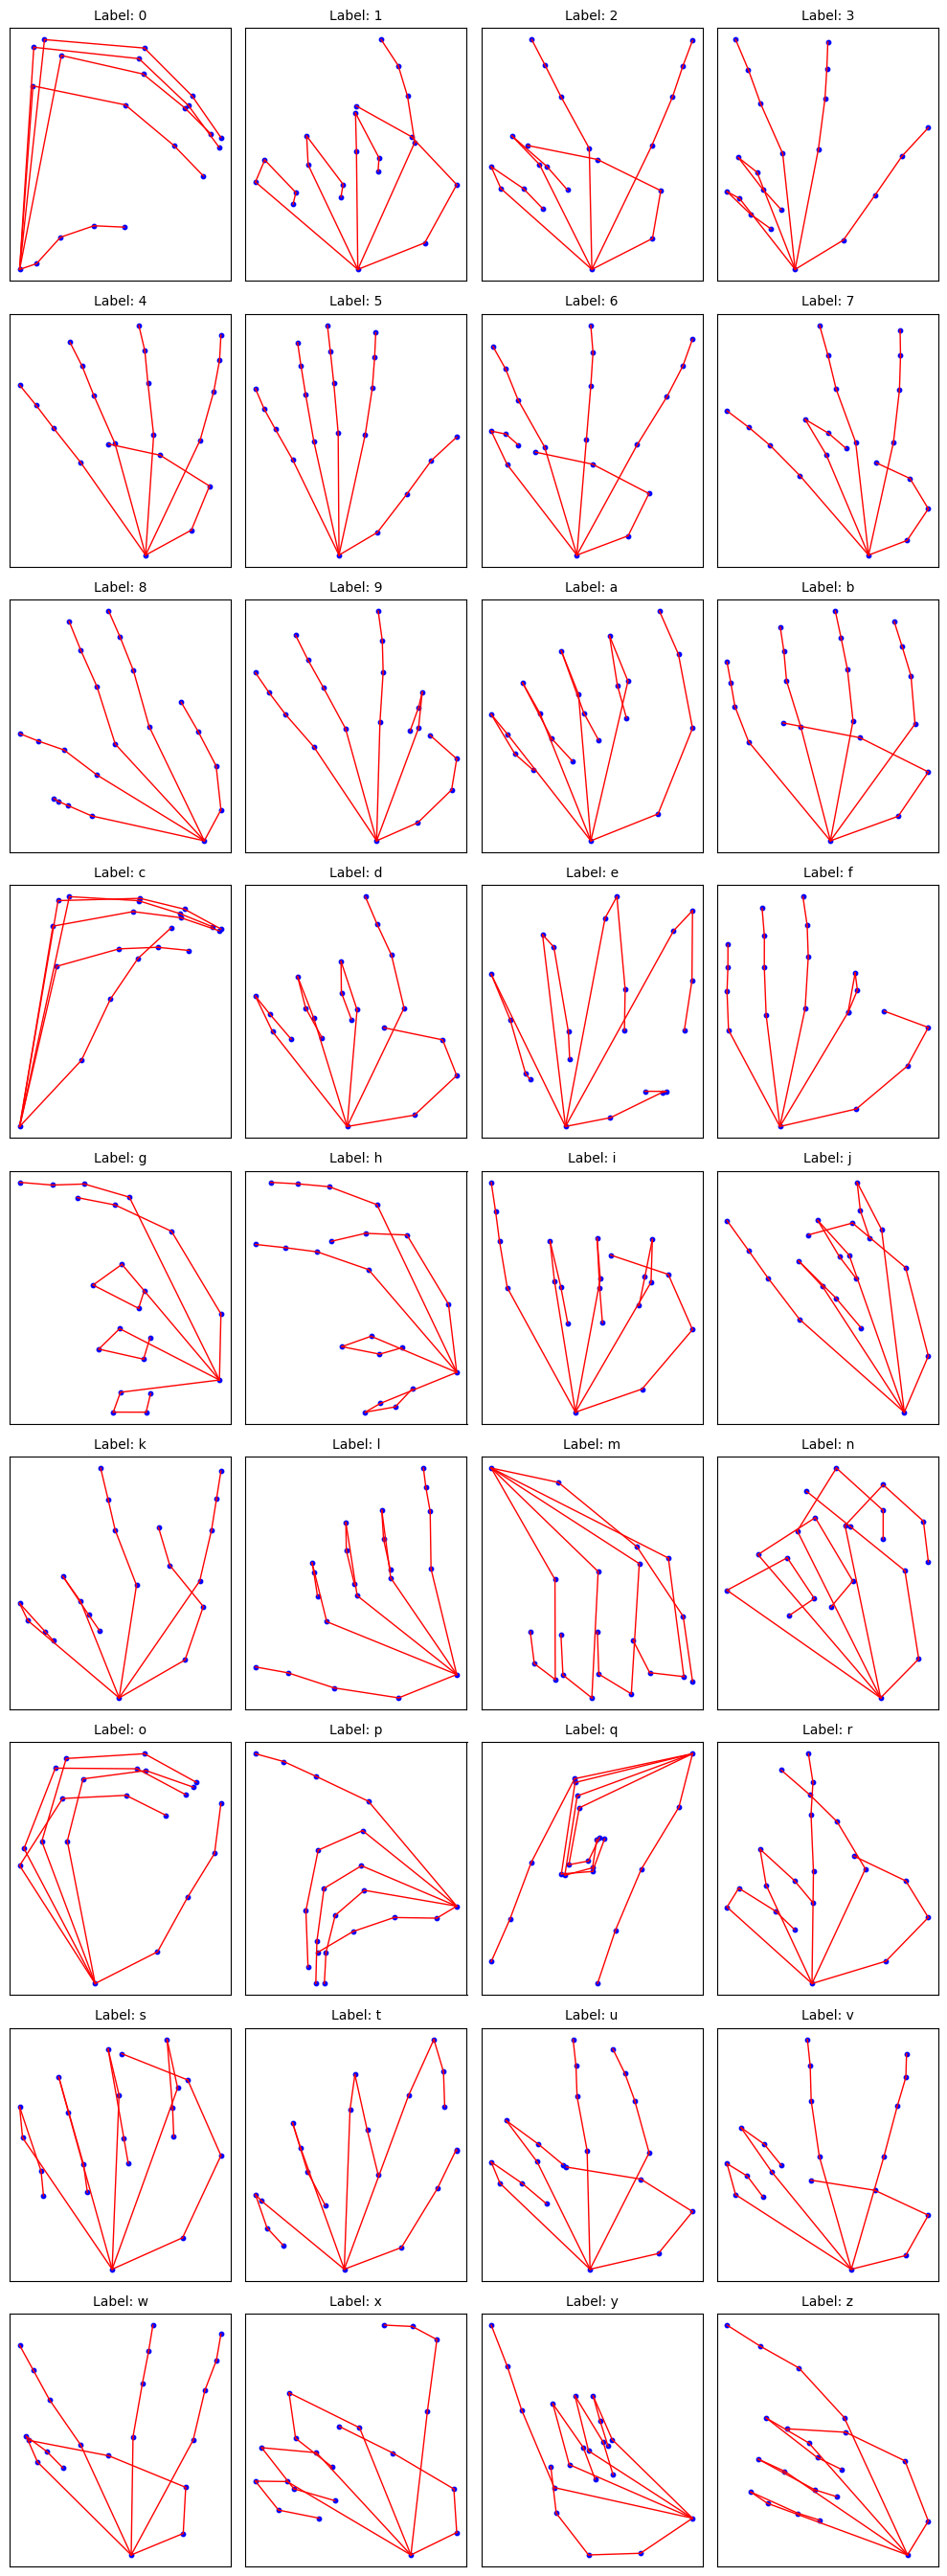

In [8]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Function to extract and store landmarks as numerical values
def extract_landmark_values(landmarks, label):
    if landmarks is None:
        return None
    
    landmarks = np.array(landmarks).reshape(-1, 3)  # Convert to (21,3) format
    
    # Store landmarks as a list of dictionaries
    landmark_data = {
        "label": label,
        "landmarks": [{"x": lm[0], "y": lm[1], "z": lm[2]} for lm in landmarks],
        "connections": [(0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                        (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                        (0, 17), (17, 18), (18, 19), (19, 20)]  # Pinky
    }
    
    return landmark_data

# Function to visualize landmarks
def plot_landmarks(ax, landmarks, label):
    if landmarks is None:
        ax.set_title(f"No landmarks for {label}")
        ax.axis("off")
        return
    
    landmarks = np.array(landmarks).reshape(-1, 3)  # Convert to (21,3) format
    
    ax.scatter(landmarks[:, 0], -landmarks[:, 1], c='blue', s=10)  # Smaller points
    
    # Define connections based on MediaPipe hand structure
    connections = [(0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                   (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                   (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                   (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                   (0, 17), (17, 18), (18, 19), (19, 20)]  # Pinky

    for start, end in connections:
        ax.plot([landmarks[start, 0], landmarks[end, 0]],
                 [-landmarks[start, 1], -landmarks[end, 1]], 'r-', linewidth=1)

    ax.set_title(f"Label: {label}", fontsize=10)
    ax.set_xticks([])  # Remove x-axis labels
    ax.set_yticks([])  # Remove y-axis labels

# Store landmark data for each label
landmark_data_list = []

unique_labels = sorted(set(y))  # Extract unique labels from dataset

num_labels = len(unique_labels)
num_cols = 4  # 4 plots per row
num_rows = max(1, (num_labels + num_cols - 1) // num_cols)  # Ensure at least 1 row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))
axes = axes.flatten()

for i, label in enumerate(unique_labels):
    idxs = np.where(y == label)[0]
    if len(idxs) == 0:
        continue  # Skip if no landmarks for this label
    idx = idxs[0]  # Get first occurrence of label
    
    # Extract numerical values
    landmark_values = extract_landmark_values(X[idx], label)
    if landmark_values:
        landmark_data_list.append(landmark_values)
    
    # Plot visualization
    plot_landmarks(axes[i], X[idx], label)

# Hide empty subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()





In [ ]:
# Save landmarks as JSON file
with open('hand_landmarks_data.json', 'w') as json_file:
    json.dump(landmark_data_list, json_file, indent=4)

print("\n✅ Hand landmark values successfully saved to 'hand_landmarks_data.json'.\n")

# Optional: Display numerical values in a readable format
for idx, data in enumerate(landmark_data_list):
    print("=" * 40)
    print(f"📌 Label: {data['label']}")
    print(f"🖐 Total Landmarks: {len(data['landmarks'])}")
    print("=" * 40)

    # Print landmark coordinates in a structured way
    print(f"{'Index':<6} {'X':<10} {'Y':<10} {'Z':<10}")
    print("-" * 40)
    for i, lm in enumerate(data["landmarks"]):
        print(f"{i:<6} {lm['x']:<10.5f} {lm['y']:<10.5f} {lm['z']:<10.5f}")

    print("\n🔗 Connections:")
    for conn in data["connections"]:
        print(f"({conn[0]} → {conn[1]})", end="  ")
    
    print("\n" + "=" * 40 + "\n")




✅ Hand landmark values successfully saved to 'hand_landmarks_data.json'.

📌 Label: 0
🖐 Total Landmarks: 21
Index  X          Y          Z         
----------------------------------------
0      0.30984    0.33478    0.00000   
1      0.34161    0.32744    -0.06766  
2      0.38676    0.29367    -0.12517  
3      0.44968    0.27905    -0.17029  
4      0.50700    0.28080    -0.21111  
5      0.33491    0.10041    -0.13183  
6      0.50873    0.12465    -0.17934  
7      0.60056    0.17676    -0.19903  
8      0.65579    0.21552    -0.21129  
9      0.33650    0.05112    -0.12090  
10     0.53444    0.06560    -0.16718  
11     0.62745    0.12544    -0.17654  
12     0.68499    0.17853    -0.18033  
13     0.35661    0.04127    -0.11101  
14     0.54469    0.05207    -0.15644  
15     0.63429    0.11315    -0.16095  
16     0.68875    0.16637    -0.15795  
17     0.38836    0.06156    -0.10550  
18     0.54233    0.08529    -0.14158  
19     0.62075    0.12857    -0.14905  
20     0.67

In [9]:
import cv2
import mediapipe as mp
import numpy as np
import joblib

# Load Model
clf = joblib.load('D:/University_Stuff/Year2/Semester2/Artificial_Intelligence/ProjectAI/asl_rf_model.pkl')

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles  # For better visualization
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Function to extract hand landmarks from webcam frame
def extract_landmarks_from_frame(frame, results):
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            return np.array(landmarks).reshape(1, -1)  # Return the reshaped array
    return None

# Start Webcam Capture
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert BGR to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    # Extract landmarks and predict
    landmarks = extract_landmarks_from_frame(frame, results)
    if landmarks is not None:
        prediction = clf.predict(landmarks)[0]
        cv2.putText(frame, f'Predicted: {prediction}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Draw hand landmarks on the frame
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                frame, 
                hand_landmarks, 
                mp_hands.HAND_CONNECTIONS,
                mp_drawing_styles.get_default_hand_landmarks_style(),
                mp_drawing_styles.get_default_hand_connections_style()
            )

    # Show the output frame
    cv2.imshow('ASL Detection', frame)

    # Exit on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
